# Capstone 3 - Final Modeling

### Table of contents
* [1.0 Intorduction](#1.0)
    * [1.1 Purpose](#1.1)
    * [1.2 Approach](#1.2)
* [2.0 Load the data](#2.0)
    * [2.1 Imports](#2.1)
    * [2.2 Load data](#2.2)
    * [2.3 Prepare data for modeling](#2.3)
    * [2.4 Function for parsing data into store/product family combinations](#2.4)
    * [2.5 MAPE and R^2 functions for evaluating analyses](#2.5)
    * [2.6 Function for modeling each time series using ARIMA](#2.6)
* [3.0 Modeling results](#3.0)
    * [3.1 Saving results to CSV file](#3.1)
    * [3.2 Reviewing top results](#3.2)
    * [3.3 Performance means](#3.3)
    * [3.4 Visualizing MAPE and R^2 distributions](#3.4)
    * [3.5 Check for non-analyzable time series](#3.5)
    * [3.6 Comparing predictability of product families](#3.6)
    * [3.7 Weighting evaluation metrics by product family sales volume](#3.7)
    * [3.8 Final weighted evaluation metrics](#3.8)
* [4.0 Visualizing select model forecasts](#4.0)
    * [4.1 Top performers](#4.1)
    * [4.2 Poor performers](#4.2)
* [5.0 Summary](#5.0)

### 1.0 Introduction: <a id='1.0'></a>

In order to stay in business, commercial grocery stores must offer prices that are commensurate with competitors, offer deals to entice customers, and accurately predict which products, and the quantity of those products, to keep in stock. These considerations are confounded by the effect of both seasonal and regional trends.

Especially for grocers, the consequences of poor inventory management are dire. Perishable items like fruits and vegetables can rot before selling if they are overstocked. Conversely, many locations do not have the real estate or capability to store overstocked, low-demand items that are not selling. According to Retail Wire, overstocking costs the average retailer 3.2% in lost revenue, while understocking items can cost 4.1%. A review of the data has shown that overstocks are costing retailers \\$123.4 billion every year, and understocks remove another \\$129.5 billion from net inflows. [1]

#### 1.1 Purpose<a id='1.1'></a>

Using Kaggle data available from Favorita grocery stores located in Ecuador [2], we will assess and predict sales of available items using time series analysis. There are multiple datasets that will require some data to be merged. We have information on transactions, stores, regions, holidays, and even oil pricing.

[1] https://www.retailwire.com/discussion/retailers-suffer-the-high-cost-of-overstocks-and-out-of-stocks/

[2] Alexis Cook, DanB, inversion, Ryan Holbrook. (2021). Store Sales - Time Series Forecasting. Kaggle. https://kaggle.com/competitions/store-sales-time-series-forecasting


#### 1.2 Approach<a id='1.2'></a>

We will use machine learning time series analysis to forecast sales of different types of items across dozens of stores. This will allow Favorita to become more efficient with its distribution of resources, and more likely to attract customers to purchase certain products at certain times. This analysis can also inform the company of the best times to offer discounts, whether to stock up on certain items, and knowledge of general market trends.


### 2.0 Load our data<a id='2.0'></a>

#### 2.1 Imports<a id='2.1'></a>

In [53]:
# import needed modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from datetime import datetime
import seaborn as sns
import os
import scipy
from sklearn.metrics import mean_squared_error
from datetime import timedelta, datetime
from numpy.polynomial.polynomial import polyfit
from scipy.stats import pearsonr
from matplotlib.pyplot import figure
from sktime.forecasting.tbats import TBATS
from pmdarima.arima import ARIMA as pmdARIMA
from pmdarima.preprocessing import FourierFeaturizer

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### 2.2 Load data<a id='2.2'></a>

In [3]:
df = pd.read_csv('./favorita_data.csv')

In [4]:
df

,Unnamed: 0,store_nbr,family,sales,onpromotion,city,state,type,cluster,local_holiday,regional_holiday,national_holiday,transactions,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,1.0,0.0,93.14
1,2013-01-02,1,AUTOMOTIVE,2.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,2111.0,93.14
2,2013-01-03,1,AUTOMOTIVE,3.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,1833.0,92.97
3,2013-01-04,1,AUTOMOTIVE,3.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,1863.0,93.12
4,2013-01-05,1,AUTOMOTIVE,5.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,1.0,1509.0,93.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,2017-08-11,9,SEAFOOD,23.831000,0.0,Quito,Pichincha,B,6,0.0,0.0,1.0,1848.0,48.81
3008012,2017-08-12,9,SEAFOOD,16.859001,4.0,Quito,Pichincha,B,6,0.0,0.0,0.0,1920.0,48.81
3008013,2017-08-13,9,SEAFOOD,20.000000,0.0,Quito,Pichincha,B,6,0.0,0.0,0.0,1745.0,48.81
3008014,2017-08-14,9,SEAFOOD,17.000000,0.0,Quito,Pichincha,B,6,0.0,0.0,0.0,1971.0,47.59


#### 2.3 Prepare data for modeling<a id='2.3'></a>

In [5]:

df = df.rename(columns={'Unnamed: 0':'date'})
df['date'] = pd.to_datetime(df["date"])
df=df.set_index(df.columns[0])
df

,store_nbr,family,sales,onpromotion,city,state,type,cluster,local_holiday,regional_holiday,national_holiday,transactions,dcoilwtico
date,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,1.0,0.0,93.14
2013-01-02,1,AUTOMOTIVE,2.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,2111.0,93.14
2013-01-03,1,AUTOMOTIVE,3.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,1833.0,92.97
2013-01-04,1,AUTOMOTIVE,3.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,1863.0,93.12
2013-01-05,1,AUTOMOTIVE,5.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,1.0,1509.0,93.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,9,SEAFOOD,23.831000,0.0,Quito,Pichincha,B,6,0.0,0.0,1.0,1848.0,48.81
2017-08-12,9,SEAFOOD,16.859001,4.0,Quito,Pichincha,B,6,0.0,0.0,0.0,1920.0,48.81
2017-08-13,9,SEAFOOD,20.000000,0.0,Quito,Pichincha,B,6,0.0,0.0,0.0,1745.0,48.81


#### 2.4 Function for parsing data into store/product family combinations<a id='2.4'></a>

In [6]:
def df_organize(df, var1, var2):
    
    v1_list = df[var1]
    v2_list = df[var2]
    
    length = len(v1_list.unique())*len(v2_list.unique())
    
    list_df = []
    z=0
    
    for e, v1 in enumerate(v1_list.unique()):
        for n, v2 in enumerate(v2_list.unique()):
            
            new_df = df[(v1_list==v1) & (v2_list==v2)]
            list_df.append(new_df)
            w = n+z+1
            print("", end="\r{} of {} dataframes organized".format(w,length))
        z = w
    
    return list_df 

In [7]:
list_df = df_organize(df, 'store_nbr', 'family')

1782 of 1782 dataframes organized

#### 2.5 MAPE and R^2 functions for evaluating analyses<a id='2.5'></a>

In [8]:
def mape(y_true, y_pred):
    
    mapes = []
    
    for e in range(len(y_true)):
        if y_true[e]!=0:
            mapes.append(np.abs((y_true[e] - y_pred[e]) / y_true[e]))
        else:
            mapes.append(np.abs((y_true[e] - y_pred[e] / np.mean(y_true))))
    
    mape_stat = round(np.mean(mapes) * 100,2)
    return mape_stat


def r2(y_true, y_pred):
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
    r2_val = round(r_value**2,5)
    return r2_val

#### 2.6 Function for modeling each time series using ARIMA<a id='2.6'></a>

In [17]:
def run_ARIMAs(df_list,prediction_horizon=16):
    
    start_time = datetime.now()
    #code to time

    
    new_df = []
    w = 0
    length = len(df_list)
    
    model_names = []
    mapes = []
    r2s = []

    
    for df in df_list:

        store = df['store_nbr'].unique()[0]
        family = df['family'].unique()[0]
        sales = df['sales']
        promos = df['onpromotion']

        try:        
            
            ff365 = FourierFeaturizer(365.25,1)
            y_prime365, ff365_fit = ff365.fit_transform(sales)
            ff30 = FourierFeaturizer((365.25/12),1)
            y_prime30, ff30_fit = ff30.fit_transform(sales)
            ff14 = FourierFeaturizer((14),1)
            y_prime14, ff14_fit = ff14.fit_transform(sales)
            ff15 = FourierFeaturizer(((365.25/12))/2,1)
            y_prime15, ff15_fit = ff15.fit_transform(sales)

            exog = pd.DataFrame({'date': sales.index})

            ff365_fit= ff365_fit.set_index(pd.PeriodIndex(exog['date'], freq='D'))
            ff30_fit= ff30_fit.set_index(pd.PeriodIndex(exog['date'], freq='D'))
            ff14_fit= ff14_fit.set_index(pd.PeriodIndex(exog['date'], freq='D'))
            ff15_fit= ff15_fit.set_index(pd.PeriodIndex(exog['date'], freq='D'))

            exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
            exog = pd.concat([exog,ff365_fit,ff30_fit,ff14_fit,ff15_fit],axis=1)
            exog = exog.drop(columns=['date'])

            exog['promo'] = promos.values

            exog_to_trainfp = exog.iloc[:-16]
            exog_to_testfp = exog.iloc[-16:]


            train = sales.iloc[:-16]
            test = sales.iloc[-16:]


            sarima = pmdARIMA(order = (1,0,1), seasonal_order = (0,1,1,7))
            sarima.fit(train, X=exog_to_trainfp.values)
            sarima_pred = sarima.predict(n_periods=len(test),X=exog_to_testfp)


            model_name = 'Store_{} - {}'.format(store,family)
            model_mape = mape(test,sarima_pred)
            model_r2 = r2(test,sarima_pred)


            model_names.append(model_name)
            mapes.append(model_mape)
            r2s.append(model_r2)
            
            w += 1
            print("", end="\r{} of {} dataframes modeled ({}%)".format(w,length,round(100*w/length)))                             
        except:
            try:
                sarima_pred = np.mean(sales)


                model_name = 'Store_{} - {}'.format(store,family)
                model_mape = mape(test,sarima_pred)
                model_r2 = r2(test,sarima_pred)

                model_names.append(model_name)
                mapes.append(model_mape)
                r2s.append(model_r2)


                w += 1
                print("", end="\r{} of {} dataframes modeled ({}%)".format(w,length,round(100*w/length)))
            except:
                
                sarima_pred = 0
                
                model_name = 'Store_{} - {}'.format(store,family)
                model_names.append(model_name)
                mapes.append(np.nan)
                r2s.append(np.nan)


                w += 1
                print("", end="\r{} of {} dataframes modeled ({}%)".format(w,length,round(100*w/length)))

                                                
    compare_series = pd.DataFrame(np.array([model_names,mapes,r2s]).T,columns=['Store/Product','MAPE','R^2'])
    end_time = datetime.now()
    print('\nDuration: {}'.format(end_time - start_time))
    
    return compare_series
                                                 

### 3.0 Modeling results<a id='3.0'></a>

In [19]:
all_dfs = run_ARIMAs(list_df,prediction_horizon=16)
all_dfs

1782 of 1782 dataframes modeled (100%)Duration: 3:07:56.094062


,Store/Product,MAPE,R^2
0,Store_1 - AUTOMOTIVE,79.07,0.05203
1,Store_1 - BABY_CARE,nan,nan
2,Store_1 - BEAUTY,66.83,0.09228
3,Store_1 - BEVERAGES,17.83,0.55825
4,Store_1 - BOOKS,496.29,0.18965
...,...,...,...
1777,Store_9 - POULTRY,15.09,0.44717
1778,Store_9 - PREPARED_FOODS,25.51,0.20726
1779,Store_9 - PRODUCE,11.8,0.74855
1780,Store_9 - SCHOOL_AND_OFFICE_SUPPLIES,59.6,0.19047


In [20]:
all_dfs['MAPE'] = all_dfs['MAPE'].astype('float64')
all_dfs['R^2'] = all_dfs['R^2'].astype('float64')


#### 3.1 Saving results to CSV file<a id='3.1'></a>

In [31]:
fav = './favorita_maper2.csv'
all_dfs.to_csv(fav)

#### 3.2 Reviewing top results<a id='3.2'></a><a id='top-performers'></a>

[Jump to model visualizations](#model-viz)


##### 3.2.1 Top R^2 results

In [21]:
all_dfs.sort_values("R^2",ascending=False).head(20)

,Store/Product,MAPE,R^2
493,Store_22 - SCHOOL_AND_OFFICE_SUPPLIES,18.09,0.96659
723,Store_29 - PRODUCE,9.23,0.96396
1066,Store_39 - EGGS,52.61,0.95296
822,Store_31 - PRODUCE,7.85,0.95250
789,Store_30 - PRODUCE,12.41,0.95079
1152,Store_40 - PRODUCE,10.00,0.94494
1297,Store_45 - EGGS,7.56,0.93279
1705,Store_7 - LIQUOR_WINE_BEER,15.27,0.92791
855,Store_32 - PRODUCE,10.97,0.92781
1542,Store_51 - MEATS,9.58,0.92661


Already, we can see that consumable items like produce, eggs, beverages, meats, and poultry are most accurate to predict. This is intuitive since people tend to make regular (periodic) visits to the store for items that are essential for existence and not reusable - like food and drinks.

The surprise champion of R^2 evaluation is school and office supplies. This is quite the outlier when considering that the other top performers are all consumable. Judging by the time of year, there could be a "back-to-school" effect in play.

Another thing to note is the erratic MAPE scoring, even among the best R^2 values. We will visualize and discuss R^2 vs MAPE evaluation in a future section below.

##### 3.2.2 Top MAPE results

In [35]:
all_dfs.sort_values("MAPE",ascending=True).head(20)

,Store/Product,MAPE,R^2
1146,Store_40 - MEATS,5.14,0.68992
540,Store_24 - GROCERY_I,5.75,0.66217
537,Store_24 - DELI,6.53,0.62729
538,Store_24 - EGGS,7.11,0.57927
894,Store_34 - BEVERAGES,7.18,0.49705
1647,Store_54 - PRODUCE,7.26,0.86999
533,Store_24 - BREAD/BAKERY,7.29,0.51961
1297,Store_45 - EGGS,7.56,0.93279
1464,Store_5 - GROCERY_I,7.75,0.58163
822,Store_31 - PRODUCE,7.85,0.95250


Again, the top results point toward edible and drinkable items as the most accurate predictions. Forecasts for meats, grocery, deli, eggs, beverages, produce, and bakery items tended to deviate less extremely from the actual sales numbers.

#### 3.3 Performance means<a id='3.3'></a>

In [237]:
r2_mean = round(np.mean(all_dfs['R^2']),3)
mape_mean = round(np.mean(all_dfs['MAPE']),2)

In [238]:
print("The mean performance on:\nMAPE metric = {}\nR^2 metric = {}".format(mape_mean,r2_mean))

The mean performance on:
MAPE metric = 53.2
R^2 metric = 0.327


#### 3.4 Visualizing MAPE and R^2 distributions<a id='3.4'></a>

We can get an idea of how the model performed across all time series with histograms.

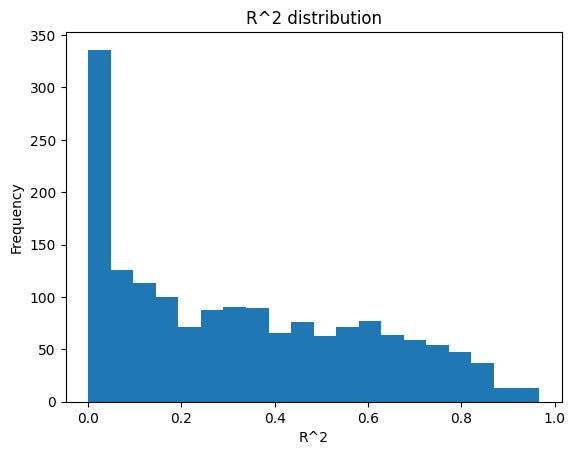

In [50]:
plt.hist(all_dfs['R^2'], bins=20)
plt.title('R^2 distribution')
plt.ylabel('Frequency')
plt.xlabel('R^2');

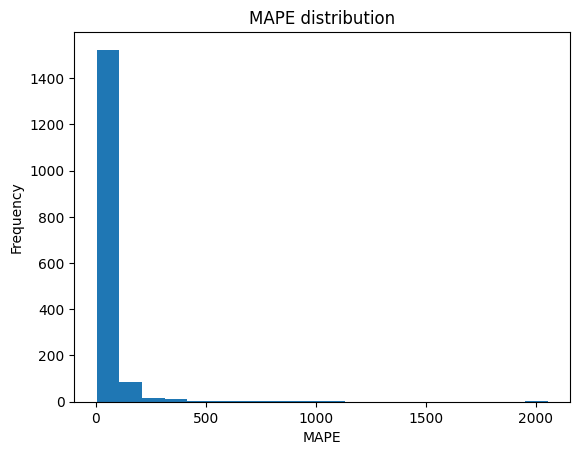

In [51]:
plt.hist(all_dfs['MAPE'], bins=20)
plt.title('MAPE distribution')

plt.ylabel('Frequency')
plt.xlabel('MAPE');

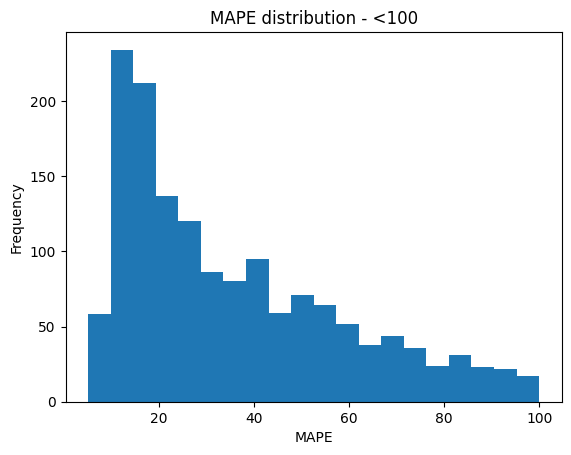

In [52]:
plt.hist(all_dfs[all_dfs['MAPE']<100]['MAPE'], bins=20)
plt.title('MAPE distribution - <100')

plt.ylabel('Frequency')
plt.xlabel('MAPE');

#### 3.5 Check for non-analyzable time series<a id='3.5'></a>

In [49]:
missing = pd.concat([all_dfs.isnull().sum(), 100 * all_dfs.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by="count" ,ascending=False)

,count,%
MAPE,129,7.239057
R^2,129,7.239057
Store/Product,0,0.000000


There appears to be 129 unique store/product combinations which do not have enough data to make a forecast. That number is roughly 7.24% of the available series. Many stores simply do not sell certian item types, which can help explain this phenomenon.

#### 3.6 Comparing predictability of product families<a id='3.6'></a>

In [224]:
products = []
mapes = []
r2s = []

for i in df['family'].unique():
    products.append(i)
    this = all_dfs[pd.DataFrame(all_dfs['Store/Product'].str.split('- ').to_list(),columns=['s','p'])['p']==i]
    r2_mean = np.mean(this['R^2'])
    mape_mean = np.mean(this['MAPE'])
    r2s.append(r2_mean)
    mapes.append(mape_mean)
    
comp = pd.DataFrame(columns=['product','r2','MAPE'])
comp['product'],comp['r2'],comp['MAPE'] = products,r2s,mapes
compare = comp.sort_values('r2',ascending=False).reset_index(drop=True)

In [225]:
compare

,product,r2,MAPE
0,PRODUCE,0.721092,12.519444
1,LIQUOR_WINE_BEER,0.619014,49.015741
2,MEATS,0.582104,21.646667
3,EGGS,0.548332,24.504815
4,DAIRY,0.520332,14.064630
5,POULTRY,0.496797,17.850370
6,GROCERY_I,0.473408,13.845741
7,BREAD/BAKERY,0.470605,15.552222
8,DELI,0.447005,16.042037
9,PERSONAL_CARE,0.443570,21.500370


This chart is very informative. The top 9 product families for R^2 are all consumables. The bottom 6 (and 11 of the bottom 12) product families are non-periodic durable goods. So this means that our model significantly more accurately predicts sales of items with known cyclical purchasing trends.

#### 3.7 Weighting evaluation metrics by product family sales volume<a id='3.7'></a>

One thing that I find helpful when evaluating an analysis which modeled many unique time series which all have the same target variable is this: weight the final evaluation metrics percent of target within each time series. For the current problem, our solution can be to calculate the percent of sales by product family, then apply those weights to R^2 and MAPE.

In [226]:
sales_total = 0
sales = []
for i in compare.iloc[:,0]:

    comp = sum(df[(df.family==i)&(df.index>'2017-07-30')]['sales'])
    sales.append(comp)
    sales_total += comp
    
compare['sales'] = sales
compare['percent of sales'] = 100*compare['sales']/sales_total
compare

,product,r2,MAPE,sales,percent of sales
0,PRODUCE,0.721092,12.519444,1.977480e+06,14.846863
1,LIQUOR_WINE_BEER,0.619014,49.015741,8.409100e+04,0.631353
2,MEATS,0.582104,21.646667,3.210705e+05,2.410588
3,EGGS,0.548332,24.504815,1.725290e+05,1.295343
4,DAIRY,0.520332,14.064630,7.210340e+05,5.413502
5,POULTRY,0.496797,17.850370,3.235603e+05,2.429281
6,GROCERY_I,0.473408,13.845741,3.980412e+06,29.884817
7,BREAD/BAKERY,0.470605,15.552222,4.667955e+05,3.504687
8,DELI,0.447005,16.042037,2.619029e+05,1.966359
9,PERSONAL_CARE,0.443570,21.500370,2.776310e+05,2.084445


We can see that, within the bounds of the forecast epoch, GROCERY_I, BEVERAGES, and PRODUCE have outsized sales numbers compared to the rest of the products. More sales volume gives more confidence in the predictions.

In [240]:
r2_s = []
mape_s = []

for i in list(range(len(compare))):

    rs = compare.iloc[i,1]*(compare.iloc[i,4]/100)
    mp = compare.iloc[i,2]*(compare.iloc[i,4]/100)
    r2_s.append(rs)
    mape_s.append(mp)

    
compare['w_R^2'] = r2_s
compare['w_MAPE'] = mape_s
final_mape,final_r2 = round(sum(compare['w_MAPE']),2),round(sum(compare['w_R^2']),3)

#### 3.8 Final weighted evaluation metrics<a id='3.8'></a>

In [241]:
print("Before weighting:\nWhole-project MAPE: {}\nWhole-project R^2: {}".format(mape_mean,r2_mean))
print("_________________")
print("After weighting:\nWhole-project MAPE: {}\nWhole-project R^2: {}".format(final_mape,final_r2))

Before weighting:
Whole-project MAPE: 53.2
Whole-project R^2: 0.327
_________________
After weighting:
Whole-project MAPE: 18.14
Whole-project R^2: 0.484


### 4.0 Visualizing select  model forecasts<a id='4.0'></a>

A function that includes a quick rehash of the model from our training notebook, along with some plotting functionality, will allow us to see the forecasts of any of the store/product combinations.

In [140]:
def see_model(df,store,family):


    df_sp = df[(df['store_nbr']==store)&(df['family']==family)]
    sales = df_sp['sales']
    promos = df_sp['onpromotion']
        

    ff365 = FourierFeaturizer(365.25,1)
    y_prime365, ff365_fit = ff365.fit_transform(sales)
    ff30 = FourierFeaturizer(30.43,1)
    y_prime30, ff30_fit = ff30.fit_transform(sales)
    ff14 = FourierFeaturizer(14,1)
    y_prime14, ff14_fit = ff14.fit_transform(sales)                                                

    exog = pd.DataFrame({'date': sales.index})

    ff365_fit= ff365_fit.set_index(pd.PeriodIndex(exog['date'], freq='D'))
    ff30_fit= ff30_fit.set_index(pd.PeriodIndex(exog['date'], freq='D'))
    ff14_fit= ff14_fit.set_index(pd.PeriodIndex(exog['date'], freq='D'))

    exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
    exog = pd.concat([exog,ff365_fit,ff30_fit,ff14_fit],axis=1)
    exog = exog.drop(columns=['date'])

    exog['promo'] = promos.values

    exog_to_trainfp = exog.iloc[:-16]
    exog_to_testfp = exog.iloc[-16:]


    train = sales.iloc[:-16]
    test = sales.iloc[-16:]


    sarima = pmdARIMA(order = (1,0,1), seasonal_order = (0,1,1,7))
    sarima.fit(train, X=exog_to_trainfp.values)
    sarima_pred = sarima.predict(n_periods=len(test),X=exog_to_testfp)
    #ci = sarima.conf_int()
    #lower_series = ci.loc['sigma2',0]
    #upper_series = ci.loc['sigma2',1]

    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(sales[sales.index>'2017-07-01'], label='part of training data')
    plt.plot(test, label='actual')
    plt.plot(sarima_pred, label='forecast')
    #plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15,label="95% confidence interval")
    plt.title('Store_{} - {} Forecast vs Actual'.format(store,family))
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.legend(loc='upper left', fontsize=8)
    plt.show();


We can start with our "top performers" in R^2 and MAPE.
* [Back up to top performers](#top-performers)</a>

#### 4.1 Top performers<a id='4.1'></a><a id='model-viz'></a>

Our top R^2 performer was a categorical outlier, in that it was a non-food item with low volume. There is likely a strong annual cycle that drove this result. As previously mentioned, "back-to-school" could be the driver. The model was fantastic at predicting Store 22 STORE AND OFFICE SUPPLIES sales accurately, but I would not read into this result too much.

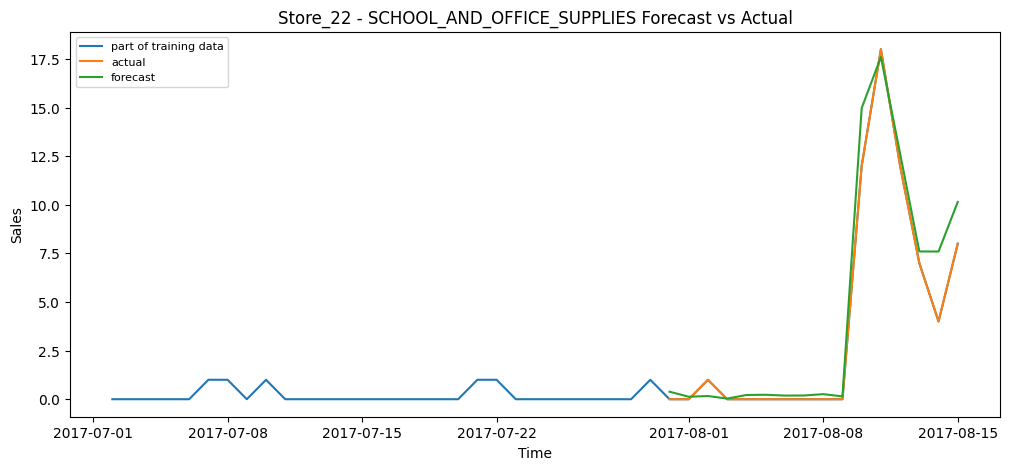

In [78]:
see_model(df,22,'SCHOOL_AND_OFFICE_SUPPLIES')

The next-best R^2 performer was indeed a consumable product category. With decent volume and obvious cycles involved, Store 29 PRODUCE predictions are incredibly close to how sales actually transpired.

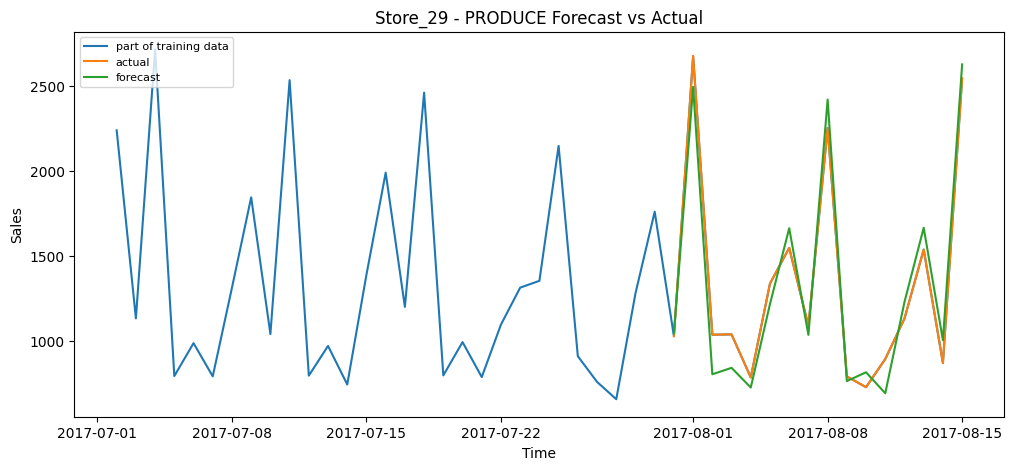

In [242]:
see_model(df,29,'PRODUCE')

Our best MAPE performer was Store 40 MEATS. As we can clearly see, MAPE is perhaps not the greatest metric. If there is a balance of much-lower-than-actual estimates and much-higher-than-actual estimates, they balance out and cause an impressive-looking MAPE result.

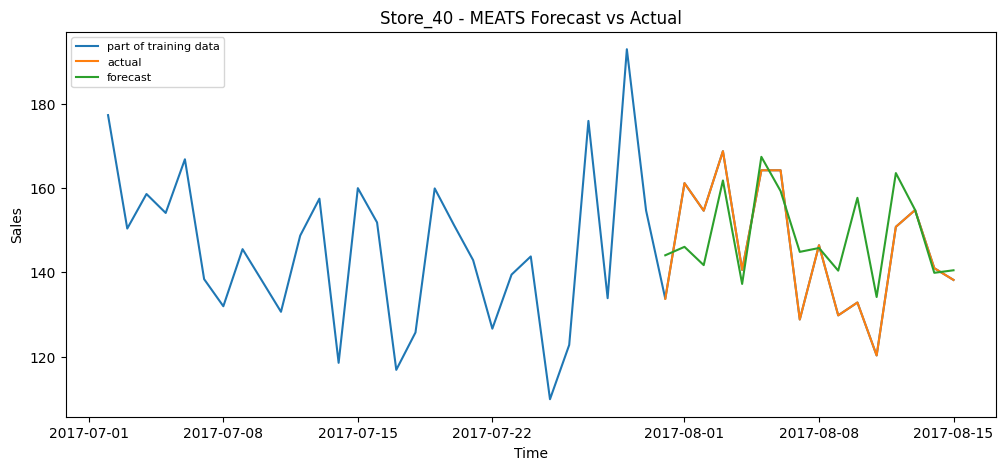

In [243]:
see_model(df,40,'MEATS')

The next-best MAPE performer was Store 24 GROCERY_I. This result appears to be more of what we would expect from a so-called, "top performer."

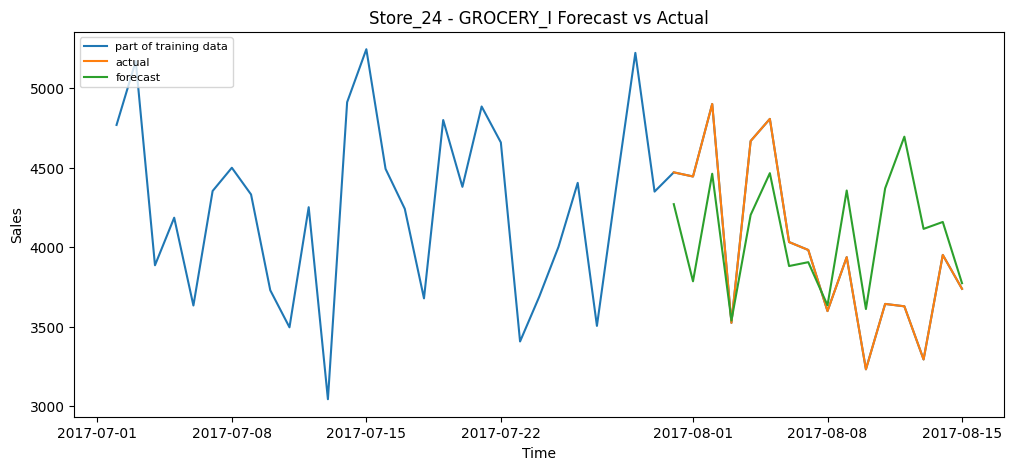

In [244]:
see_model(df,24,'GROCERY_I')

Quite a few time series performed excellently on both metrics, like Store 31 PRODUCE, and Store 45 EGGS. For many time series, the forecasted and actual values overlap entirely for significant portions of the testing epoch.

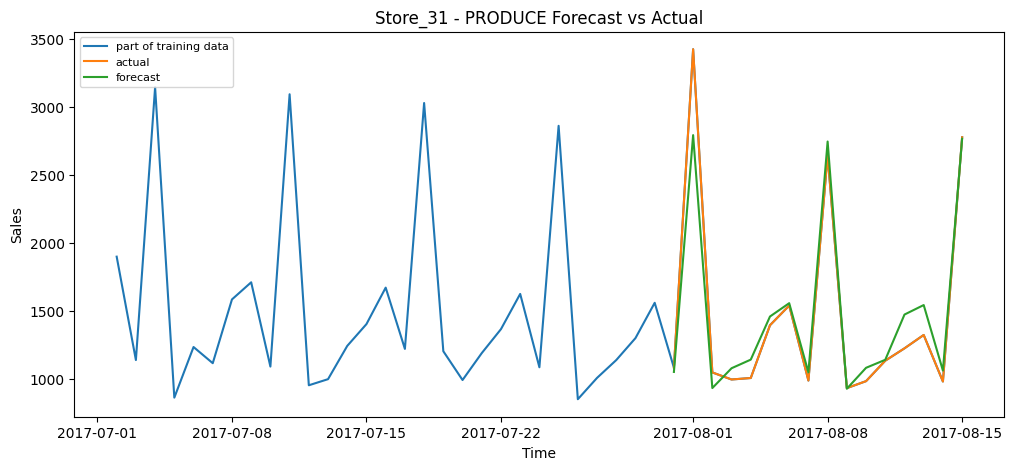

In [75]:
see_model(df,31,'PRODUCE')

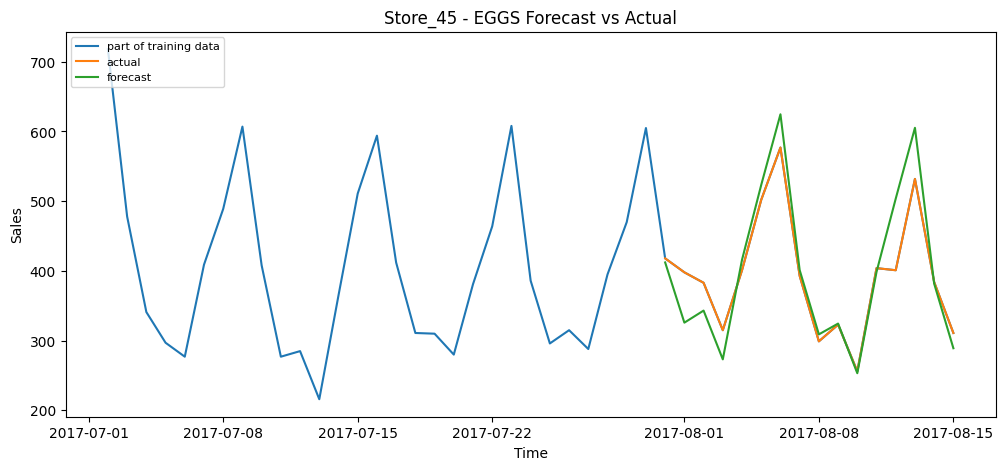

In [245]:
see_model(df,45,'EGGS')

#### 4.2 Poor performers<a id='4.2'></a>

In order to properly gain an understanding of the selected ARIMA, we should also look at a couple of instances where there were unexpected failures. Store 54 GROCERY_II has the low-volume impediment, but there was obviously an atypical spike in sales on a single day which destroyed any chance of seeing good metrics from this series' analysis. Unpredictable events do occur.

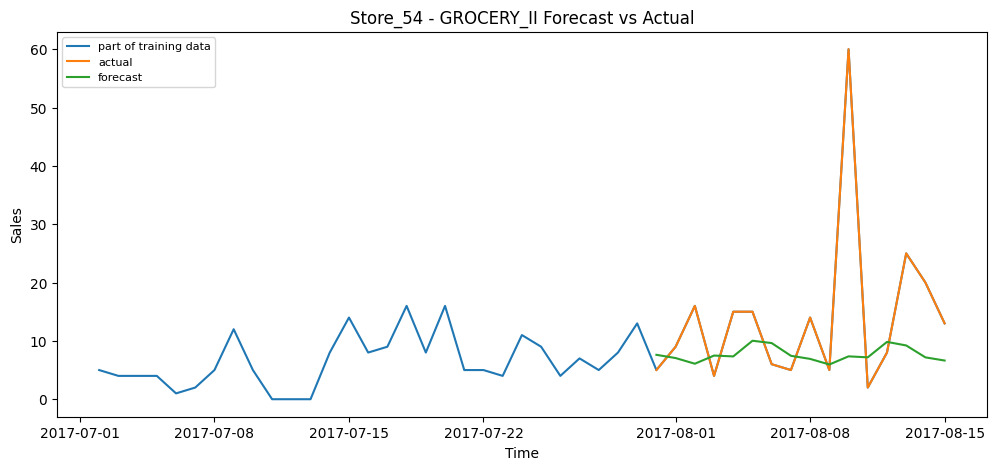

In [83]:
see_model(df,54,'GROCERY_II')

Visualizing Store 1 CELEBRATION further evidences the effect of scale on our evaluation metrics. The fact is, that low-volume stores and products can significantly skew the overall results. If the daily sales of a certain product type is predicted to be 2, but that day the store actually made 20, then the percent error for that datapoint would be 100*(20-2)/20 = 90%, even though the raw difference was only 18. Lower volume means that any changes in sales will introduce extreme variability. It only takes a few poor predictions of this kind to make a time series' mean of all absolute percent errors (MAPE metric) inaccurate overall. 

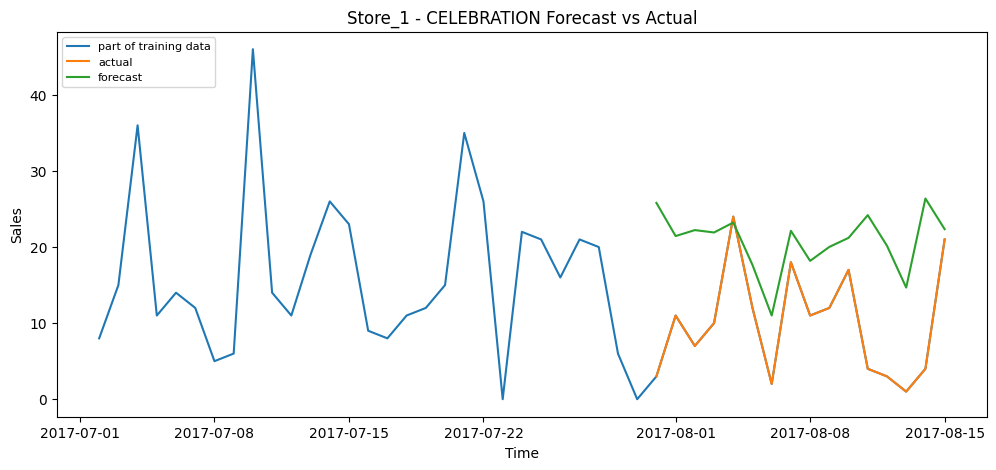

In [247]:
see_model(df,1,'CELEBRATION')

### 5.0 Summary<a id='5.0'></a>

In this Modeling notebook, I applied the exogenous variable inclusive seasonal ARIMA model (selected from the Preprocessing and Training notebook) to every one of the 1782 time series in our analysis. Runtime was just over 3 hours, but that number is considerably more time-efficient than other modeling options. The result was 1653 completed forecasts, and 129 time series without enough information to make a proper forecast. Many of the non-analyzable series were simply stores that did not sell certain product types (in which case we would predict zeros for the values).

With the time series that did contain enough information, we were able to see how certain product families had better predictability than others. Specifically, the food and drink items scored much better on our evaluation metrics (R^2 and MAPE) than durable goods items.

Overall, my model performed very well, with many of the series having R^2 values greater than 0.90! Looking at the overall performance metrics, I decided to apply weighted averages based on the actual sales volume seen for each product family. A series with a <0.02 R^2 score but sales volume averaging <5 dollars daily is neither informative nor instructive.<br>
Therefore, it was determined that adjusting the overall metrics was the best option. Once the weights were applied, we were able to see overall metrics more reflective of the true model accuracy.

Before weighting:<br>
* Whole-project MAPE: 53.2<br>
* Whole-project R^2: 0.327<br>

After weighting:<br>
* Whole-project MAPE: 18.14<br>
* Whole-project R^2: 0.484<br>